In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
sns.set(rc={'figure.figsize':(11, 4)})
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import KFold, cross_val_score as CVS
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.metrics import r2_score
from xgboost import XGBRegressor as XGBR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV as GCV
from time import time
import datetime

In [71]:
df=pd.read_csv('STD_outlier_dataset.csv')
df['deliverydate'] = pd.to_datetime(df['deliverydate'],format = "%Y-%m-%d")
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   deliverydate  266 non-null    datetime64[ns]
 1   shippedqty    266 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.3 KB


,deliverydate,shippedqty
0,2021-01-02,2675712.0
1,2021-01-03,175539.0
2,2021-01-04,861634.0
3,2021-01-05,5704518.0
4,2021-01-06,4662007.0
...,...,...
261,2021-12-26,18372.0
262,2021-12-28,2556168.0
263,2021-12-29,5204287.0
264,2021-12-30,848682.0


In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
shippedqty,266.0,2.926643e+06,1.873663e+06,204.0,1152467.5,3180915.0,4527004.0,6073431.0


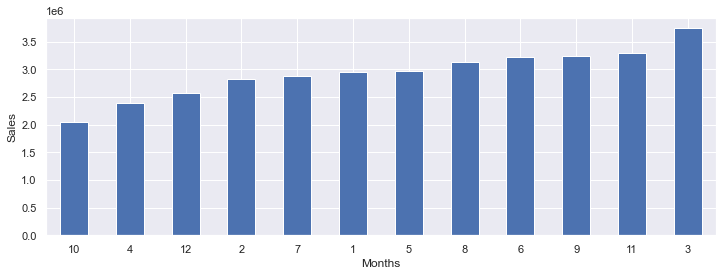

In [73]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["deliverydate"].dt.month)["shippedqty"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Months");  # custom x label using Matplotlib
plt.ylabel("Sales");

In [74]:
df['week_days'] = df['deliverydate'].dt.day_name()
df = df[['deliverydate', 'week_days', 'shippedqty']]
df

,deliverydate,week_days,shippedqty
0,2021-01-02,Saturday,2675712.0
1,2021-01-03,Sunday,175539.0
2,2021-01-04,Monday,861634.0
3,2021-01-05,Tuesday,5704518.0
4,2021-01-06,Wednesday,4662007.0
...,...,...,...
261,2021-12-26,Sunday,18372.0
262,2021-12-28,Tuesday,2556168.0
263,2021-12-29,Wednesday,5204287.0
264,2021-12-30,Thursday,848682.0


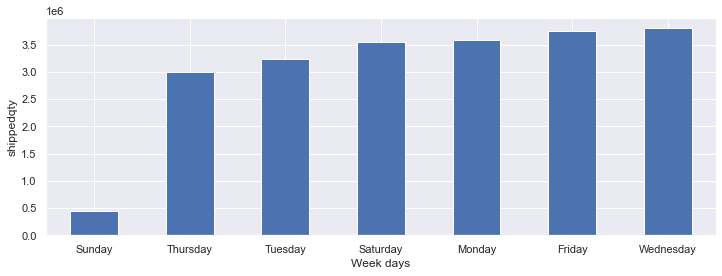

In [75]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["week_days"])["shippedqty"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Week days"); 
plt.ylabel("shippedqty");

In [76]:
k = df.resample('3D', on='deliverydate').shippedqty.sum()
k

deliverydate
2021-01-02     3712885.0
2021-01-05    12112191.0
2021-01-08     4406502.0
2021-01-11     4050525.0
2021-01-14     5951196.0
                 ...    
2021-12-19     6187854.0
2021-12-22     3761954.0
2021-12-25      232770.0
2021-12-28     8609137.0
2021-12-31     1164628.0
Freq: 3D, Name: shippedqty, Length: 122, dtype: float64

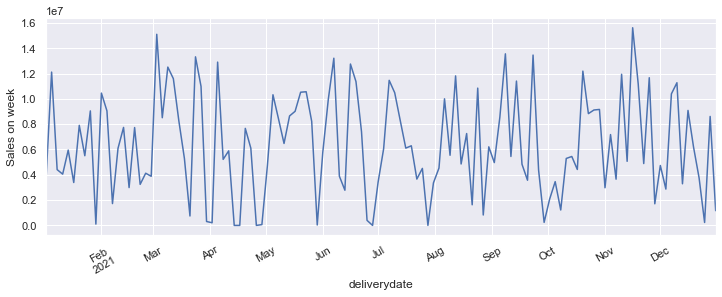

In [77]:
fig, axs = plt.subplots(figsize=(12, 4))
k.plot(kind='line', rot=30, ax=axs)
plt.xlabel("deliverydate");  
plt.ylabel("Sales on week");

In [78]:
df1 = df.copy()
df1

,deliverydate,week_days,shippedqty
0,2021-01-02,Saturday,2675712.0
1,2021-01-03,Sunday,175539.0
2,2021-01-04,Monday,861634.0
3,2021-01-05,Tuesday,5704518.0
4,2021-01-06,Wednesday,4662007.0
...,...,...,...
261,2021-12-26,Sunday,18372.0
262,2021-12-28,Tuesday,2556168.0
263,2021-12-29,Wednesday,5204287.0
264,2021-12-30,Thursday,848682.0


In [79]:
df1["rolling_qty_7D"] = df1['shippedqty'].rolling(window= 7, min_periods=1).sum().astype(int)
df1["rolling_sales_14D"] = df1['shippedqty'].rolling(window= 14, min_periods=1).sum().astype(int)

In [80]:
df = df1.copy()
rowcount  = 0
for row in open("STD_outlier_dataset.csv"):
    rowcount+= 1
print("Number of rows present:", rowcount)
rows=int(rowcount*0.3)
train=df.iloc[:-rows]
test=df.iloc[-rows:]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)


Number of rows present: 267
Train Dataset: (186, 5)
Test Dataset: (80, 5)


In [81]:
b = []
for i in train.keys():
    b.append(i)
print(b) 

['deliverydate', 'week_days', 'shippedqty', 'rolling_qty_7D', 'rolling_sales_14D']


In [82]:
b.remove('week_days')
b.remove('deliverydate')
print(b)

['shippedqty', 'rolling_qty_7D', 'rolling_sales_14D']


In [83]:
X_train = train[b].values
X_test = test[b].values
y_train = train['shippedqty'].values
y_test = test['shippedqty'].values
X_test.shape

(80, 3)

In [84]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train,y_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## (N_estimators)

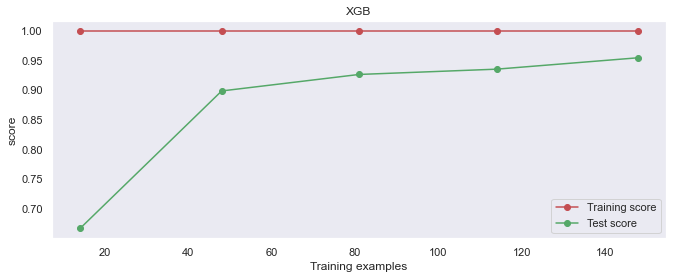

In [85]:
def plot_learning_curve(estimator, title, train, test,ax=None,ylim=None,cv=None,n_jobs=None):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, train, test,shuffle=True,cv=cv,random_state=420,n_jobs=n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel ("Training examples")
    ax.set_ylabel("score")
    ax.grid()
    ax.plot(train_sizes, np.mean(train_scores, axis=1),"o-",color="r", label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',color="g", label="Test score")
    ax. legend (loc="best")
    return ax
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100, random_state=420), "XGB" , X_train, y_train, ax=None, cv=cv)
plt. show()

260 0.9558760624736211 0.9558760624736211
10 0.939140692429806 0.939140692429806
260 0.9558760624736211 0.9558760624736211 0.0022530977738130786


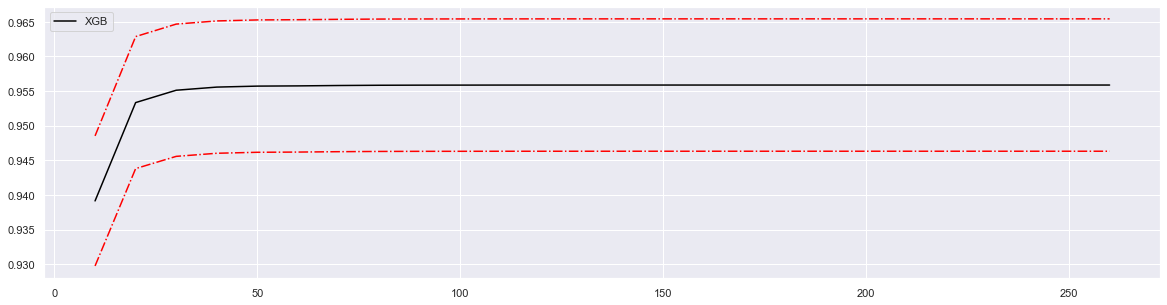

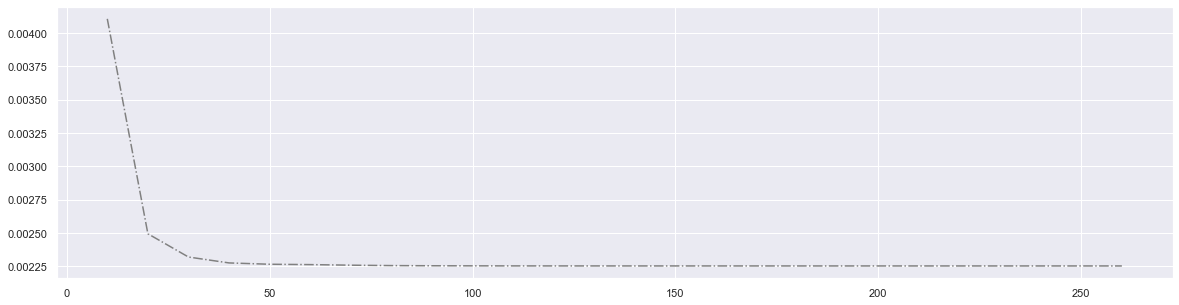

In [86]:
axisx=range(10,rowcount,10)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg=XGBR(n_estimators=i,random_state=420)
    cvresult=CVS(reg,X_train,y_train,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.mean())
    ge.append((1-cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle="-.")
plt.show()

In [87]:
time0 = time()
print(XGBR(n_estimators=100,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9076239668749978
0.12083292007446289


In [88]:
time0 = time()
print(XGBR(n_estimators=260,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9076606292687323
0.2250058650970459


In [89]:
time0 = time()
print(XGBR(n_estimators=80,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.9075675326294587
0.0930640697479248


In [90]:
time0 = time()
print(XGBR(n_estimators=75,random_state=420).fit(X_train,y_train).score(X_test,y_test))
print(time()-time0)

0.907555408166361
0.09164619445800781


## (Subsample)

0.44999999999999996 0.9741873056553001 0.9741873056553001
0.05 0.9312308795958704 0.9312308795958704
0.3 0.973887156454075 0.973887156454075 0.0007275459079776435


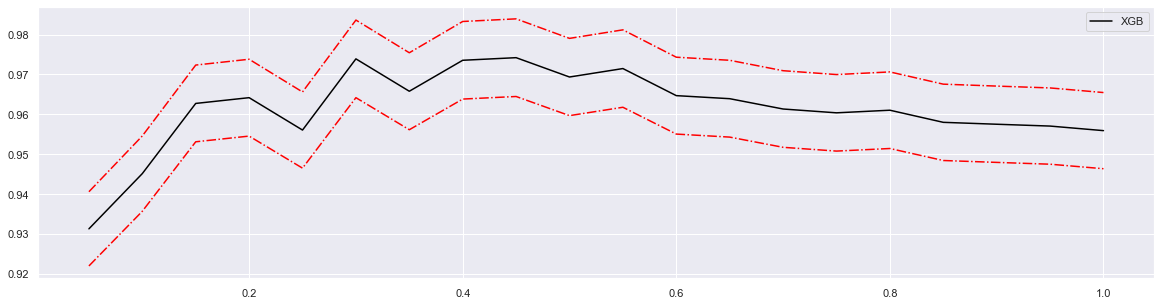

In [91]:
axisx=np.linspace(0.05,1,20)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg=XGBR(n_estimators=260,subsample=i,random_state=420)
    cvresult=CVS(reg,X_train,y_train,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.mean())
    ge.append((1-cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()

In [92]:
reg=XGBR(n_estimators=260,subsample=0.3,random_state=420).fit(X_train,y_train)

In [93]:
reg.score(X_test,y_test)

0.9253497607580392

In [94]:
MSE(y_test,reg.predict(X_test))

267811996581.52206

## (Scoring)

In [95]:
def regassess(reg,X_train,y_train,cv,scoring=['r2'],show=True):
    score=[]
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i],CVS(reg,X_train,y_train ,cv=cv,scoring=scoring[i]).mean()))
        score.append(CVS(reg,X_train,y_train,cv=cv,scoring=scoring[i]).mean())
    return score

In [96]:
regassess(reg,X_train,y_train,cv,scoring=['r2','neg_mean_squared_error'])

r2:0.97
neg_mean_squared_error:-84992298016.28


[0.973887156454075, -84992298016.2835]

In [97]:
for i in [0,0.15,0.2,0.25,0.35,1]:
    time0=time()
    reg = XGBR(n_estimators=260,random_state=420,learning_rate=i)
    print("learning_rate = {}".format(i))
    regassess(reg,X_train,y_train,cv,scoring = ["r2","neg_mean_squared_error"])
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
    print("\t")

learning_rate = 0
r2:-2.87
neg_mean_squared_error:-12791565260031.14
00:03:363719
	
learning_rate = 0.15
r2:0.96
neg_mean_squared_error:-139095878768.42
00:02:843712
	
learning_rate = 0.2
r2:0.95
neg_mean_squared_error:-150891218046.21
00:02:261478
	
learning_rate = 0.25
r2:0.96
neg_mean_squared_error:-146902262990.54
00:02:477202
	
learning_rate = 0.35
r2:0.95
neg_mean_squared_error:-147715155521.93
00:02:296879
	
learning_rate = 1
r2:0.91
neg_mean_squared_error:-299084116167.44
00:01:426866
	


0.15000000000000002 0.9570069232679614


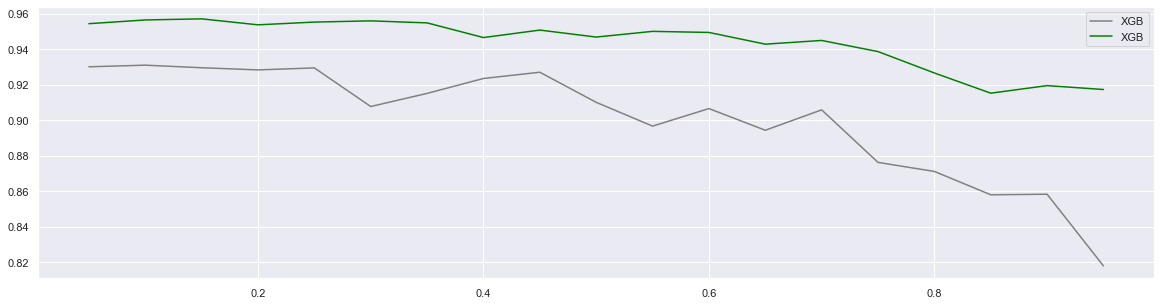

In [98]:
axisx=np.arange(0.05,1,0.05)
rs=[]
te=[]
for i in axisx:
    reg = XGBR(n_estimators=180,random_state=420,learning_rate=i)
    score = regassess(reg,X_train,y_train,cv,scoring =["r2","neg_mean_squared_error"],show=False)
    test = reg.fit(X_train,y_train).score(X_test,y_test)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,te,c="gray",label="XGB")
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

## (booster)

In [99]:
for booster in ["gbtree","gblinear","dart"]:
    reg = XGBR(n_estimators=260,learning_rate=0.15,random_state=420,booster=booster).fit(X_train,y_train)
    print(booster)
    print(reg.score(X_test,y_test))

gbtree
0.9294911758337008
gblinear
0.9999999999998499
dart
0.9294911758337008


## (Objective)

In [100]:
reg=XGBR(n_estimators=180,random_state=420).fit(X_train,y_train)
reg.score(X_test,y_test)
MSE(y_test,reg.predict(X_test))

331274359620.2576

In [101]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
dtrain

In [102]:
param={'silent':True,
       'objective':'reg:linear'
       ,'eta':0.15}
num_round=260

### shift+tab can see the function of the code

In [103]:
bst=xgb.train(param,dtrain,num_round)

[15:43:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [104]:
preds=bst.predict(dtest)
print('r2:',r2_score(y_test,preds))
print('MSE:',MSE(y_test,preds))

r2: 0.9294911758337008
MSE: 252954433479.93866


## （Gamma->Complexity control)

0.05 0.9558760667487641
0.9 0.955875838454275 0.00030616543263583136
0.5 0.9558760426404277 0.0003061671766483972 0.0022530907897177523


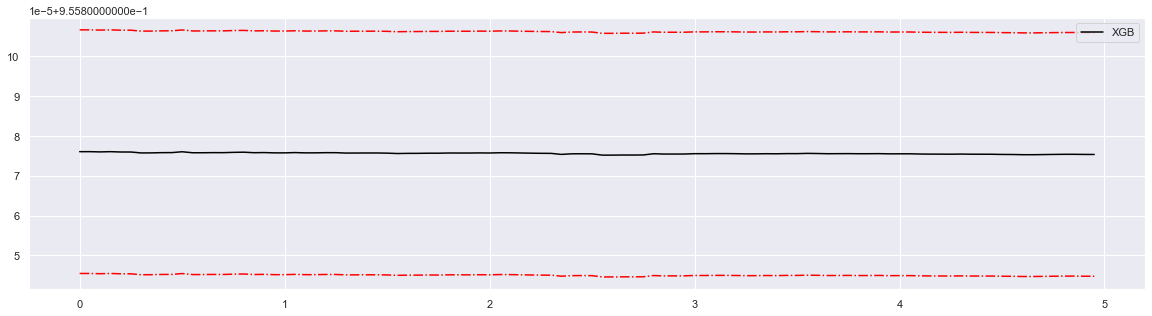

In [105]:
axisx=np.arange(0,5,0.05)
rs=[]
var=[]
ge=[]
for i in axisx:
    reg = XGBR(n_estimators=260,random_state=420,gamma=i)
    result=CVS(reg,X_train,y_train,cv=cv)
    rs.append(result.mean())
    var.append(result.var())
    ge.append((1-result.mean())**2+result.var())
print(axisx[rs.index(max(rs))],max(rs))
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs=np.array(rs)
var=np.array(var)*0.1
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c='Black',label='XGB')
plt.plot(axisx,rs+var,c="red",linestyle="-.")
plt.plot(axisx,rs-var,c="red",linestyle="-.")
plt.legend()
plt.show()

In [106]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
param1={"silent":True,
        "obj":'reg:linear'
       ,'gamma':0}
num_round=260
n_fold=5

In [107]:
time0=time()
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

[15:44:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:44:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:44:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

In [108]:
cvresult1.head(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.571684e+06,33055.025413,2.589101e+06,155998.038352
1,1.863658e+06,21770.880133,1.908082e+06,100017.262764
2,1.357761e+06,14736.945062,1.417633e+06,74470.276253
3,9.985386e+05,11742.777855,1.074802e+06,62742.301399
4,7.404064e+05,10259.160676,8.384300e+05,48661.195297


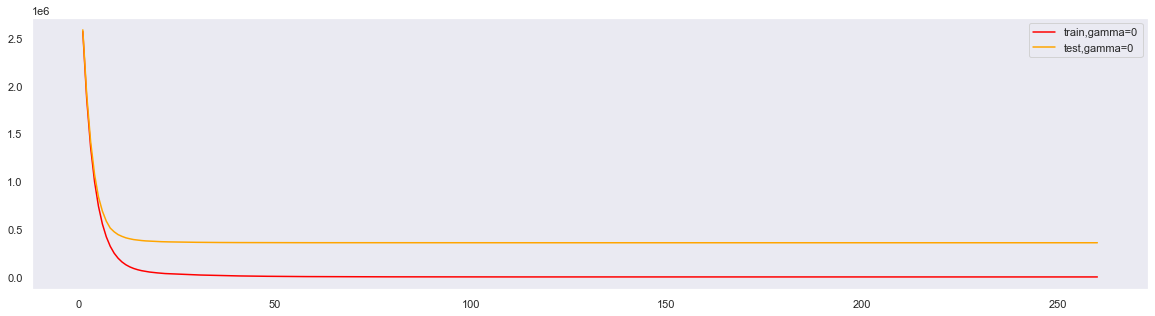

In [109]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,261),
         cvresult1.iloc[:,0],
         c='red',label='train,gamma=0')
plt.plot(range(1,261),
         cvresult1.iloc[:,2],
         c='orange',label='test,gamma=0')
plt.legend()
plt.show()

[15:44:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:44:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:44:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

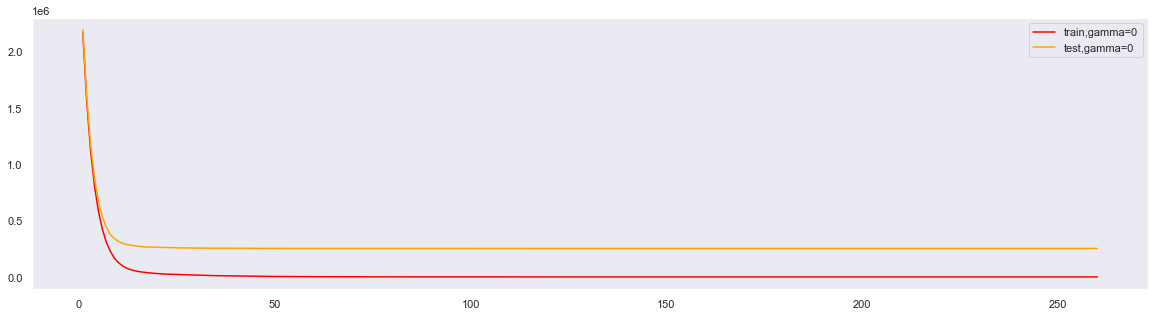

In [110]:
param1={"silent":True,
        "obj":'reg:linear'
       ,'gamma':0,"eval_metric":"mae"}
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,261),
         cvresult1.iloc[:,0],
         c='red',label='train,gamma=0')
plt.plot(range(1,261),
         cvresult1.iloc[:,2],
         c='orange',label='test,gamma=0')
plt.legend()
plt.show()

## (full testing)

00:00:885154
00:00:428906
00:00:577081


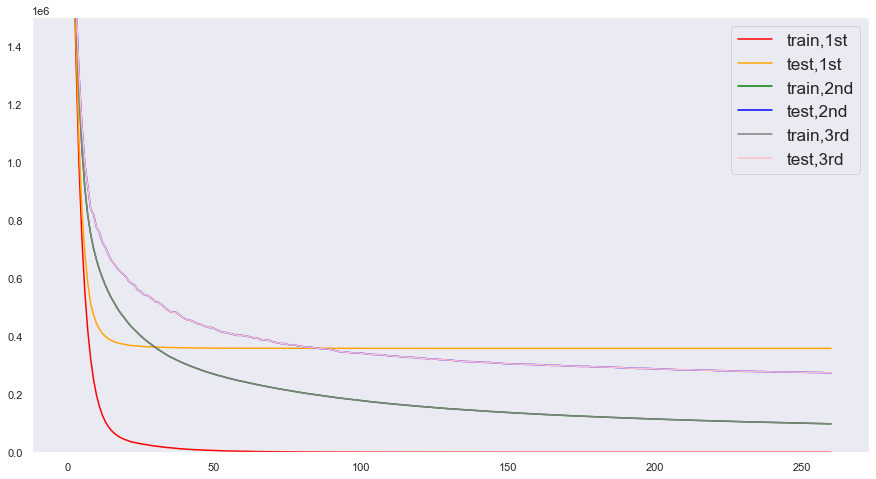

In [117]:
param1={'subsample':1
        ,'max_depth':6
        ,'eta':0.3
        ,'gamma':0
        ,'lambda':1
        ,'alpha':0
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
param2={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.15
        ,'lambda':1
        ,'alpha':1
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
param3={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.15
        ,'lambda':1
        ,'alpha':1
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
num_round=260
n_fold=5
time0=time()
cvresult1=xgb.cv(param1,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0=time()
cvresult2=xgb.cv(param2,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

time0=time()
cvresult3=xgb.cv(param3,dtrain,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

fig,ax=plt.subplots(1,figsize=(15,8))
ax.grid()
ax.set_ylim(top=1500000)
ax.plot(range(1,261),
         cvresult1.iloc[:,0],
         c='red',label='train,1st')
ax.plot(range(1,261),
         cvresult1.iloc[:,2],
         c='orange',label='test,1st')
ax.plot(range(1,261),
         cvresult2.iloc[:,0],
         c='green',label='train,2nd')
ax.plot(range(1,261),
         cvresult2.iloc[:,2],
         c='blue',label='test,2nd')
ax.plot(range(1,261),
         cvresult3.iloc[:,0],
         c='gray',label='train,3rd')
ax.plot(range(1,261),
         cvresult3.iloc[:,2],
         c='pink',label='test,3rd')
ax.legend(fontsize="x-large")
plt.show()

## Save data and run

In [65]:
import pickle

In [66]:
dtrain=xgb.DMatrix(X_train,y_train)

In [118]:
param={'subsample':1
        ,'max_depth':1
        ,'eta':0.3
        ,'gamma':0.15
        ,'lambda':1
        ,'alpha':1
        ,'colsample_bytree':1
        ,'colsample_bylevel':1
        ,'colsample_bynode':1
       }
num_round=260
n_fold=5

In [119]:
bst=xgb.train(param,dtrain,num_round)

In [120]:
pickle.dump(bst,open("xgboostSTD.dat","wb"))